In [1]:
# In[]
import sys
from ml_toolkit import encode_str_columns, write_excel_sheet_v2, fetch_train_test_split

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, plot_confusion_matrix
from xgboost import XGBClassifier


from IPython.display import Markdown as md

#### define methods for fetching feature importance from xgboost models

In [2]:
def fetch_feature_importance( data, feature_importances ):
    feature_importance = sorted( dict( 
        zip( 
            data.drop( columns = [ output_column ]).columns, 
            feature_importances
            )
        ).items(), key = lambda x : x[1], reverse = True
    )
    return feature_importance

def filter_data_for_imp_variables( data, feature_importance, output_column ):
    feature_importance = fetch_feature_importance( data, feature_importance )
    imp_variables = [ x for x,y in feature_importance if y > 0 ]
    imp_variables = imp_variables + [ output_column ]
    return data[ imp_variables ]

In [3]:
data = pd.read_csv( r"output\data\data_filtered_imputed_clean.csv", dtype = 'category' )
output_column = "Suicide"

#### filter data for deaths due to health issues, and Suicides

In [4]:
data = data.loc[ data[ output_column ].isin( [ '1', '0' ] ) ]
data.drop( columns = [ 'Follow', 'Povpct' ], inplace = True, errors = 'ignore' )

#### one-hot encode the data

In [5]:
factorization_technique = 'one-hot'
data_ = encode_str_columns( data.astype( str ), technique = factorization_technique, str_attributes = None, max_unique_values_allowed_for_str = None, drop_extras = False, output_column = output_column )
data_.columns = data_.columns.str.replace( ".", "" ).str.replace( ",|-", "_" ).str.replace( " ", "_" )
for x in data_.columns:
    data_[ x ] = data_[x].astype( int )

write_excel_sheet_v2( data_, "output/data/xgb_classifier/data_encoded.xlsx" )

string columns found: ['Sex', 'Hhnum', 'Majocc', 'Majind', 'Ssnyn', 'Working', 'Age', 'Pob', 'Stater']
encoding Sex, Ssnyn, Working, Age, Stater, Majocc, Pob, Hhnum, Majind using one-hot
time taken to create dummy variables: 0.0100 secs
finally writing .xlsx file: 'data_encoded.xlsx'


WindowsPath('output/data/xgb_classifier/data_encoded.xlsx')

In [6]:
scores = {}
training_scores = {}

In [7]:
# split into train-test
X_train, X_test, y_train, y_test = fetch_train_test_split( data_, output_column, test_size = 0.25, random_state = 42, stratify = True )

#### build a basic XGBoost classifier

[0]	validation_0-aucpr:0.68490
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.69199
[2]	validation_0-aucpr:0.68660
[3]	validation_0-aucpr:0.69178
[4]	validation_0-aucpr:0.69122
[5]	validation_0-aucpr:0.69163
[6]	validation_0-aucpr:0.69159
[7]	validation_0-aucpr:0.69158
[8]	validation_0-aucpr:0.69058
[9]	validation_0-aucpr:0.68972
Accuracy: 0.6543778801843319


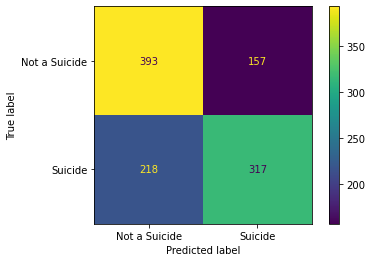

In [8]:
# XGBoost
model = XGBClassifier( 
    objective = 'binary:logistic',
    seed = 42,
    missing = None,
    min_child_weight = 0, learning_rate = 0.01, n_estimators= 10
)
model.fit( 
    X_train, y_train, 
    verbose = True, early_stopping_rounds = 10, eval_metric = 'aucpr',
    eval_set = [ ( X_test, y_test ) ]
)

scores[ 'raw' ] = accuracy_score( y_test, model.predict( X_test ) )
training_scores[ 'raw' ] = accuracy_score( y_train, model.predict( X_train ) )
print( "Accuracy: {0}".format( scores[ 'raw' ] ) )
plot_confusion_matrix( model, X_test, y_test, values_format = 'd', display_labels = [ "Not a Suicide", "Suicide" ] )

#### find optimal parameters for XGBoost classifier using cross validation (GridSearchCV)

Fitting 3 folds for each of 1080 candidates, totalling 3240 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    1.9s
[Parallel(n_jobs=10)]: Done 142 tasks      | elapsed:    7.6s
[Parallel(n_jobs=10)]: Done 345 tasks      | elapsed:   16.8s
[Parallel(n_jobs=10)]: Done 628 tasks      | elapsed:   30.6s
[Parallel(n_jobs=10)]: Done 993 tasks      | elapsed:   47.5s
[Parallel(n_jobs=10)]: Done 1438 tasks      | elapsed:  1.2min
[Parallel(n_jobs=10)]: Done 1965 tasks      | elapsed:  1.7min
[Parallel(n_jobs=10)]: Done 2572 tasks      | elapsed:  2.4min
[Parallel(n_jobs=10)]: Done 3240 out of 3240 | elapsed:  3.1min finished


params: {'colsample_bytree': 1.0, 'gamma': 0.3, 'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 5, 'scale_pos_weight': 1}

 score: 0.738581078027996
Accuracy: 0.6737327188940092


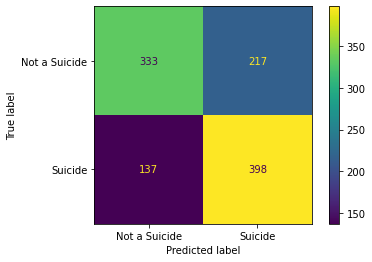

In [9]:
# round 1
param_grid = {
    'max_depth' : range( 3, 10, 2 ),
    "learning_rate" : [ 0.1, 0.01, 0.05 ],
    'gamma' : [ i / 10.0 for i in range( 0, 5 ) ],
    'min_child_weight' : range( 1, 6, 2 ),
    "colsample_bytree" : [ 0.5, 0.9, 1.0 ],
    "scale_pos_weight" : [ 0.7, 1 ]
}
optimal_params = GridSearchCV(
    estimator = XGBClassifier( objective = 'binary:logistic', seed = 42, 
    subsample = 0.9, colsample_bytree = 0.5 ),
    param_grid = param_grid, scoring = 'roc_auc',
    verbose = 2,
    n_jobs = 10,
    cv = 3
)

optimal_params.fit( X_train, y_train,
    early_stopping_rounds = 25,
    eval_metric = 'auc',
    eval_set = [ ( X_test, y_test ) ],
    verbose = False
)

model = optimal_params.best_estimator_
print( "params: {0}\n\n score: {1}".format( optimal_params.best_params_, optimal_params.best_score_ ) )
# print( fetch_feature_importance( data_, model.feature_importances_ ) )
scores[ 'cv_1' ] = accuracy_score( y_test, model.predict( X_test ) )
training_scores[ 'cv_1' ] = accuracy_score( y_train, model.predict( X_train ) )
print( "Accuracy: {0}".format( scores[ 'cv_1' ] ) )
plot_confusion_matrix( model, X_test, y_test, values_format = 'd', display_labels = [ "Not a Suicide", "Suicide" ] )

In [10]:
md(
    """the model filters below attributes to be not useful, and having zero importance towards the outcome variable : \n'{0}'""".format( 
    "', '".join( np.setdiff1d( data_.columns, filter_data_for_imp_variables( data_, model.feature_importances_, output_column ).columns.tolist() ) )
)
  )

the model filters below attributes to be not useful, and having zero importance towards the outcome variable : 
'Hhnum_10', 'Hhnum_11', 'Hhnum_12', 'Hhnum_13', 'Hhnum_14', 'Hhnum_16', 'Hhnum_6', 'Hhnum_8', 'Hhnum_9', 'Majind_1', 'Majind_10', 'Majind_13', 'Majind_14', 'Majind_2', 'Majind_3', 'Majind_5', 'Majind_7', 'Majocc_11', 'Majocc_6', 'Majocc_7', 'Majocc_8', 'Majocc_9', 'Pob_A_country_in_Central_America', 'Pob_A_country_in_Eastern_Europe', 'Pob_A_country_in_Western_Europe', 'Pob_A_country_not_on_a_continent_(identified_as_an_island)', 'Pob_A_country_on_South_America_Continent', 'Pob_African_Continent', 'Pob_Asian_Continent_', 'Pob_Elsewhere_but_not_in_the_US', 'Pob_Mexico', 'Pob_North_America_(Not_US_or_Mexico)', 'Pob_Not_in_the_US__PR__or_outlying_possession', 'Sex_2', 'Ssnyn_1', 'Stater_East_South_Central_Division', 'Stater_South_Atlantic_Division', 'Working_0', 'Working_1'

In [11]:
# filter out insignificant variables from the data 
data_ = filter_data_for_imp_variables( data_, model.feature_importances_, output_column )
X_train, X_test, y_train, y_test = train_test_split( data_.drop( columns = [output_column] ), data_[ output_column ], test_size = 0.25, random_state = 42, stratify = data_[ output_column ] )

#### perform a second round of cross validation to find optimal parameters
this time, the operation is baselined on the optimal parameters observed in first round

Fitting 3 folds for each of 2000 candidates, totalling 6000 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  22 tasks      | elapsed:    0.4s
[Parallel(n_jobs=10)]: Done 264 tasks      | elapsed:    6.5s
[Parallel(n_jobs=10)]: Done 670 tasks      | elapsed:   16.2s
[Parallel(n_jobs=10)]: Done 1236 tasks      | elapsed:   30.9s
[Parallel(n_jobs=10)]: Done 1966 tasks      | elapsed:   50.8s
[Parallel(n_jobs=10)]: Done 2856 tasks      | elapsed:  1.3min
[Parallel(n_jobs=10)]: Done 3910 tasks      | elapsed:  1.8min
[Parallel(n_jobs=10)]: Done 5022 tasks      | elapsed:  2.4min
[Parallel(n_jobs=10)]: Done 5711 tasks      | elapsed:  2.8min
[Parallel(n_jobs=10)]: Done 6000 out of 6000 | elapsed:  3.0min finished


{'colsample_bytree': 0.5, 'gamma': 0.15, 'learning_rate': 0.09, 'max_depth': 4, 'min_child_weight': 2}
Accuracy: 0.6645161290322581


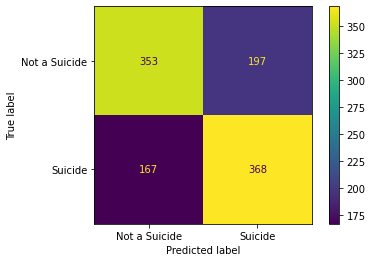

In [12]:
# round 2
param_grid = {
    "max_depth" : [ 4, 6, 7, 8, 10 ],
    "learning_rate" : [ 0.01, 0.05, 0.075, 0.08, 0.09 ],
    "gamma" : [ 0, 0.1, 0.15, 0.25 ],
    "min_child_weight" : [ 2, 3, 4, 6 ],
    "colsample_bytree" : [ 0.5, 0.6, 0.75, 0.9, 1 ]
}

optimal_params = GridSearchCV(
    estimator = XGBClassifier( objective = 'binary:logistic', seed = 42, 
    subsample = 0.9, colsample_bytree = 0.5 ),
    param_grid = param_grid, scoring = 'roc_auc',
    verbose = 2,
    n_jobs = 10,
    cv = 3
)

optimal_params.fit( X_train, y_train,
    early_stopping_rounds = 25,
    eval_metric = 'auc',
    eval_set = [ ( X_test, y_test ) ],
    verbose = False
)

model = optimal_params.best_estimator_
print( optimal_params.best_params_ )
# print( fetch_feature_importance( data_, model.feature_importances_ ) )
scores[ 'cv_2' ] = accuracy_score( y_test, model.predict( X_test ) )
print( "Accuracy: {0}".format( scores[ 'cv_2' ] ) )
plot_confusion_matrix( model, X_test, y_test, values_format = 'd', display_labels = [ "Not a Suicide", "Suicide" ] )

#### the second iteration has helped increase True positives, decrease False negatives- which is a good thing.
The False positives have increased, but it is not very critical because suspecting a person who might commit Suicide, but is not going to- is less harmful than the opposite case

In [13]:
md(
    """the model filters below attributes to be not useful, and having zero importance towards the outcome variable : \n'{0}'""".format( 
    "', '".join( np.setdiff1d( data_.columns, filter_data_for_imp_variables( data_, model.feature_importances_, output_column ).columns.tolist() ) )
)
  )

the model filters below attributes to be not useful, and having zero importance towards the outcome variable : 
''

#### we again filter the data for these attributes

In [14]:
data_ = filter_data_for_imp_variables( data_, model.feature_importances_, output_column )
X_train, X_test, y_train, y_test = train_test_split( data_.drop( columns = [output_column] ), data_[ output_column ], test_size = 0.25, random_state = 42, stratify = data_[ output_column ] )

In [15]:
# train with 1 estimator to plot the tree
xgb_model = XGBClassifier( 
    objective = 'binary:logistic',
    seed = 42,
    missing = None,
    gamma = 0.1,
    learning_rate = 0.09,
    max_depth = 4,
    reg_lambda = 0,
    scale_pos_weight = 1,
    n_estimators = 1, min_child_weight = 2,
    colsample_bytree = 0.6,
    subsample = 0.9
)
xgb_model.fit( 
    X_train, y_train, 
    verbose = True, early_stopping_rounds = 10, eval_metric = 'aucpr',
    eval_set = [ ( X_test, y_test ) ]
)

scores[ 'single_estimator_from_best' ] = accuracy_score( y_test, xgb_model.predict( X_test ) )
training_scores[ 'single_estimator_from_best' ] = accuracy_score( y_train, xgb_model.predict( X_train ) )

[0]	validation_0-aucpr:0.67270
Will train until validation_0-aucpr hasn't improved in 10 rounds.


In [16]:
from xgboost import to_graphviz


node_params = {
    "shape" : "box",
    "style" : "filled, rounded",
    "fillcolor" : "#78cbe"
}

leaf_params = {
    "shape" : "box",
    "style" : "filled",
    "fillcolor" : "#e48038"
}


to_graphviz(
    model, num_trees = 0, size = "10,10",
    condition_node_params = node_params,
    leaf_node_params = leaf_params
)


xg_viz = to_graphviz(
    model, num_trees = 0, size = "10,10",
    condition_node_params = node_params,
    leaf_node_params = leaf_params
)
xg_viz.render( "xgboost_viz", "output", format = 'pdf' )

'output\\xgboost_viz.pdf'

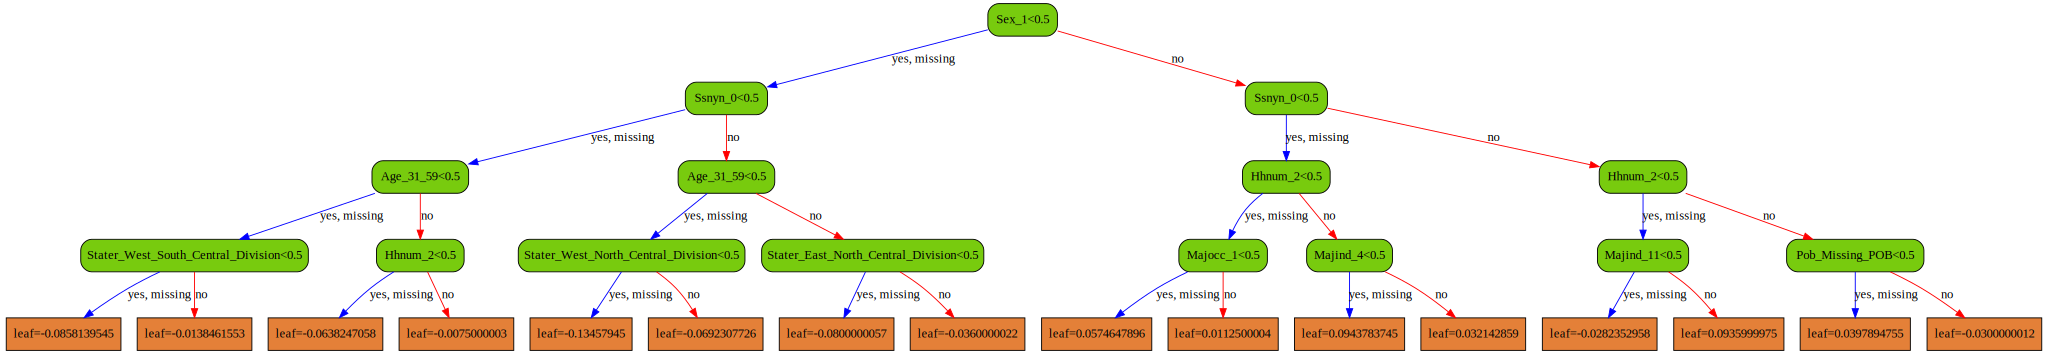

In [17]:
to_graphviz(
    model, num_trees = 0, size = "10,10",
    condition_node_params = node_params,
    leaf_node_params = leaf_params
)

Text(0.5, 1.0, 'XGBoostClassifier')

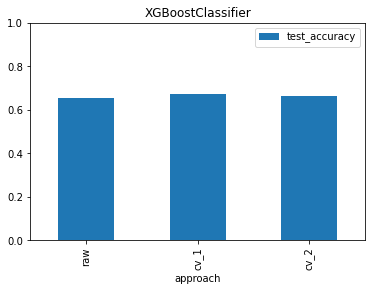

In [18]:
scores_xg = pd.DataFrame.from_dict( scores.items())
scores_xg.columns = [ "approach", "test_accuracy" ]
plt_ = scores_xg.drop(3).set_index( "approach" ).plot( kind = 'bar' )
plt_.set_ylim( bottom = 0, top = 1)
plt_.set_title( "XGBoostClassifier" )

In [ ]:
test_scores_xg = pd.DataFrame.from_dict( training_scores.items() )
test_scores_xg.columns = [ "approach", "train_accuracy" ]
scores_xg = pd.merge( scores_xg, test_scores_xg, on = "approach" )
write_excel_sheet_v2( scores_xg, "output/accuracy/xgboost.xlsx" )